# Closure Objects

This notebook is inspired by Robert Nystorm's excellent book "Crafting Interpreters".
You can find the question that inspired the idea in here: https://craftinginterpreters.com/closures.html#challenges

## Closures

What is a closure?
Usually, a function defines its own scope. Local variables that are created inside the function - cease to exist when the function returns.

That "cease to exist" means that objects are no longer reachable and they get garbage-collected.
I want to show you that objects inside functions don't exist after the function returns - but how can I demonstrate that I _cannot_ access an object anymore?

For that we will use the `weakref` Python library, which enables us to hold pointers to objects but doesn't prevent them from getting garbage-collected.
When a weakref points to a collected object, it says that the object is "dead".

In [1]:
import gc
import weakref

# Creating a minimal object we can track
class TrackedObject:     
    pass

def func():
    global ref  # we'll want to see the value of `ref` after the function ends
    obj = TrackedObject()
    ref = weakref.ref(obj)
    return

func()
gc.collect()  # force garbage collection so `obj` gets collected
print(ref)

<weakref at 0x000001DEF9C35E90; dead>


However, functions can "close-over" values from outer scopes - making them live even after the function has returned:

In [2]:
def func():
    global ref
    obj = TrackedObject()
    ref = weakref.ref(obj)
    def inner():
        return obj  # closes over `obj` from outer scope
    return inner

inner_func = func()
gc.collect()
print(ref)

<weakref at 0x000001DEF9C361B0; to 'TrackedObject' at 0x000001DEFB4652E0>


Now our tracked object is still alive - that's because it is being used by a _closure_ function, which is still accessible.

## Replacing Objects with Closures

In one of the bonus challenges in his book, Robert Nystorm suggests that objects can actually be replaced by closures. He challenges us to implement a constructor to a Vector object, getter functions and addition function - without using `class`, only closures.

This is actually pretty cool:

In [3]:
def vector(x,y):
    def get(i):
        return x if i==0 else y
    return get

def get_x(vec):
    return vec(0)
    
def get_y(vec):
    return vec(1)

def vector_add(vec1, vec2):
    return vector(
        get_x(vec1) + get_x(vec2), get_y(vec1) + get_y(vec2)
    )

def print_vector(vec):
    print(f"({get_x(vec)},{get_y(vec)})")

v1 = vector(1,2)
v2 = vector(4,7)
v_sum = vector_add(v1,v2)
print_vector(v_sum)

(5,9)


What else can we do?

The first thing that came to my mind was dunder methods. Can we implement addition of closure-objects using the `+` operator?

With 'normal' Python objects, we could do that by implementing an `__add__` method in the class.
So, maybe if we add an `__add__` to our closure-objects we could use `+` on them?

Fortunately, because functions in Python are objects themselves, we can freely add attributes and methods to them, so that's what we're gonna try.

(this is actually a bit cheating, because a function in Python is actually an object - and our goal is to replace objects with closures.
However, it _will_ be awesome if we could add objects with `+`, so it's worth a try)

In [4]:
def addable_vector(x,y):
    def get(i):
        return x if i==0 else y
    get.__add__ = vector_add 
    return get

v1 = addable_vector(1,2)
v2 = addable_vector(4,7)
v_sum = v1 + v2
print_vector(v_sum)

TypeError: unsupported operand type(s) for +: 'function' and 'function'

Well, that didn't work... we have to dig deeper.

When we do `v1 + v2` what Python really does behind the scenes is `type(v1).__add__(v2)`, and not `v1.__add__(v2)`.
`type(v1)` is a `function`, which doesn't have `__add__` so we get an "unsupported" error.

Why don't we add our `__add__` method to `function` then?

In [5]:
def addable_vector(x,y):
    def get(i):
        return x if i==0 else y
    type(get).__add__ = vector_add 
    return get

v1 = addable_vector(1,2)
v2 = addable_vector(4,7)
v_sum = v1 + v2
print_vector(v_sum)

TypeError: cannot set '__add__' attribute of immutable type 'function'

We have reached a dead end - the designers of Python have decided that `function` is an immutable type, and therefore we cannot add dunder methods like normal objects.

## Playing with Time & Space

No doubt that defining closure-objects is less readable than using the traditional `class`.
Closure-objects are also more limited than objects because we can't implement dunder methods to them.
The next question we should ask ourselves is - are they more efficient than objects?


Let's start by measuring the memory consumption of closure-objects compared to objects.
But first - a few notes about memory in Python.

To properly analyze the memory consumption of closures and objects we would need a deep dive into how memory is managed inside CPython, Python's C compiler - but I feel like it is a big diversion from the main subject of this notebook.
Therefore, we are going to do some vanilla memory comparison by using `sys.getsizeof()`.
The size of an object we see when using `sys.getsizeof()` is merely the size of the references it holds to internal attributes; these can be viewed by `dir`-ing an object:

In [6]:
obj = TrackedObject()

dir(obj)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__']

We can see a long list of dunders - these are the object's internal attributes.

To prove that `sys.getsizeof()` gives us only the reference size, we can see that the size of the object's `__dict__` (which stores its attributes) is already bigger than the size of the object itself we get when using `sys.getsizeof()`:

In [9]:
import sys

print(sys.getsizeof(obj))
print(sys.getsizeof(obj.__dict__))

48
280


The size of `obj` returned by `sys.getsizeof()` is determined by what references `obj` holds in its `__dir__`.
It does not represent the real memory consumption in the system when creating an object, but it does give us a feeling of how much memory-consuming it will be to pass the object around between functions or make copies of it.

### Space Comparison

Understanding this, it is time for our ultimate test - which is heavier: "regular" objects or closure-objects?

We first start by making a `class` version of a vector for comparison:

In [10]:
class Vector:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def vector_add(self, other):
        return self.__class__(self.x+other.x, self.y+other.y)

    def print_vector(self):
        print(f"({self.x},{self.y})")

Now let's compare the size in bytes using `sys.getsizeof()`:

In [11]:
closure_vec = vector(1,2)
object_vec = Vector(1,2)

print(sys.getsizeof(closure_vec))
print(sys.getsizeof(object_vec))

160
48


It looks like our closure-object takes much more memory than regular objects; this is not because of our inefficient implementation, but a basic size difference between functions and objects in Python - function just consume more memory than objects.

Let's see which attributes of functions can be blamed for the extra weight:

In [12]:
object_attrs = dir(object_vec)
closure_attrs = dir(closure_vec)
set(closure_attrs) - set(object_attrs)

{'__annotations__',
 '__builtins__',
 '__call__',
 '__closure__',
 '__code__',
 '__defaults__',
 '__get__',
 '__globals__',
 '__kwdefaults__',
 '__name__',
 '__qualname__',
 '__type_params__'}

Most of these attributes are not too exciting - however, there is one attribute worth talking about: `__closure__`.

If we take an object and stuff it with attributes, `sys.getsizeof()` will still give us the same result - no matter the number of attributes we assign.
We *do* see the size difference in the object's `__dict__`:

In [13]:
class HeavyObject:
    def __init__(self):
        # set attributes "attr0","attr1",... with values 0,1,...
        for i in range(1000):
            setattr(self, f"attr{i}", i)

heavy_obj = HeavyObject()
print(sys.getsizeof(heavy_obj))
print(sys.getsizeof(heavy_obj.__dict__))

48
26032


The object's size indeed hasn't changed (remember that it depends on its references), but all of the attributes are stored in `__dict__` and we can see that its size increased appropriately.

What if we did the same thing with closure-objects?

In [14]:
def heavy_closure():
    attrs = {f"attr{i}":i for i in range(1000)}
    def get(j):
        return attrs[f"attr{j}"]
    return get

heavy_clos = heavy_closure()
print(sys.getsizeof(heavy_clos.__dict__))

64


Well, of course these "attributes" are not stored in `heavy_clos.__dict__` because they are not really attributes and we cannot access them with `heavy_clos.a1` like we could with an object.

But the data has to be stored _somewhere_.
We can scan `heavy_clos`'s attributes for immediate suspects:

In [15]:
for attr_name in dir(heavy_clos):
    attr = getattr(heavy_clos, attr_name)
    print(attr_name, sys.getsizeof(attr))

__annotations__ 64
__builtins__ 6576
__call__ 48
__class__ 432
__closure__ 48
__code__ 216
__defaults__ 16
__delattr__ 48
__dict__ 64
__dir__ 72
__doc__ 16
__eq__ 48
__format__ 72
__ge__ 48
__get__ 48
__getattribute__ 48
__getstate__ 72
__globals__ 1584
__gt__ 48
__hash__ 48
__init__ 48
__init_subclass__ 72
__kwdefaults__ 16
__le__ 48
__lt__ 48
__module__ 49
__name__ 44
__ne__ 48
__new__ 72
__qualname__ 67
__reduce__ 72
__reduce_ex__ 72
__repr__ 48
__setattr__ 48
__sizeof__ 72
__str__ 48
__subclasshook__ 72
__type_params__ 40


Now that's odd - none of the attributes seems big enough to store the data our closure is supposed to hold...

The answer is that data lies in the `__closure__` attribute, which is itself just a reference to a tuple of "cells" - and therefore is of small size.

In [16]:
heavy_clos.__closure__

(<cell at 0x000001DEFB6B3190: dict object at 0x000001DEFBB89340>,)

That cell is our closure version of an object's `__dict__`, and if we check its size - 

In [17]:
cell = heavy_clos.__closure__[0]
sys.getsizeof(cell.cell_contents)

26032

There is our data!

Frustrating enough, the conclusion of this section is that passing closures around is probably less efficient than objects, and even though we can't access attributes of closure-objects as easily as "regular" objects, they still have to be stored somewhere in memory.

It is time for time analysis.

### Time Comparison

I had a gut feeling that this is also going to be a losing battle for closure-objects.
"Regular" objects are such a fundamental part of the language that we should assume they are optimized beyond recognition.

When I first run the time benchmarking using Jupyter's magic `%timeit` the time variance was too large between runs, so I decided to implement a little benchmark function of my own. It probably has some flaws - benchmarking properly is far too complicated for this notebook - but at least it gave fairly stable results, so I rolled with it.

In [18]:
import time

def benchmark(func):
    start = time.perf_counter()
    for _ in range(100):
        func()
    return time.perf_counter() - start

I also made a plotting function so we can see the results of multiple test runs:

In [19]:
import matplotlib.pyplot as plt

def plot_benchmark(func1, func2, labels):
    results1 = [benchmark(func1) for _ in range(100_000)]
    results2 = [benchmark(func2) for _ in range(100_000)]
    plt.boxplot([results1, results2], tick_labels=labels, showfliers=False)
    plt.show()

We are now ready to benchmark our closure-objects.

Let's start by benchmarking instance creation:

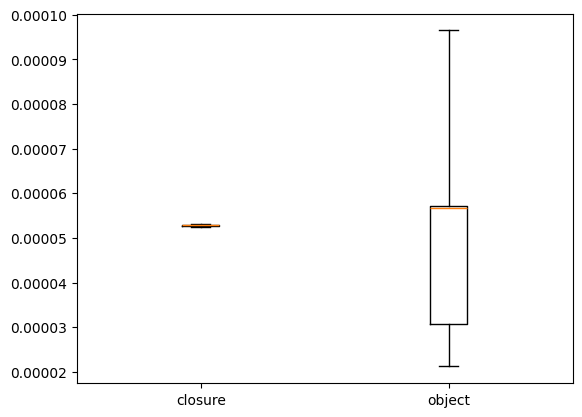

In [22]:
create_closure = lambda: vector(1,2)
create_object = lambda: Vector(1,2)

plot_benchmark(create_closure, create_object, labels=['closure', 'object'])

It looks like closure creation *is* faster than objects!
Maybe this is an unfair comparison - remember that when we are creating an object we define the `print` and `add` methods, and when creating a closure we only set up its attributes.

Let's see if something changes when we redefine the `Vector` class to have attributes only:

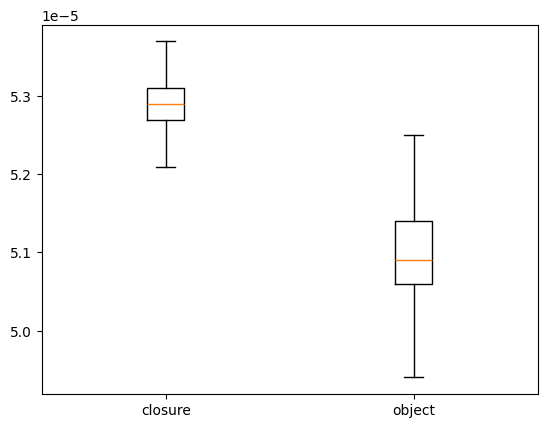

In [23]:
class AttributeOnlyVector:
    def __init__(self, x, y):
        self.x = x
        self.y = y


create_closure = lambda: vector(1,2)
create_object = lambda: AttributeOnlyVector(1,2)

plot_benchmark(create_closure, create_object, labels=['closure', 'object'])

It looks like we have managed to improve the objects' creation time to be faster than closures.

However, most class definitions will often have some (if not many) method definitions, so our first creation benchmark is closer to a real-life scenario than the attribute-only benchmark.
Closures, however, don't care about how many methods we define on them later - at creation time only attributes matter.

Speaking about methods, let's benchmark those:

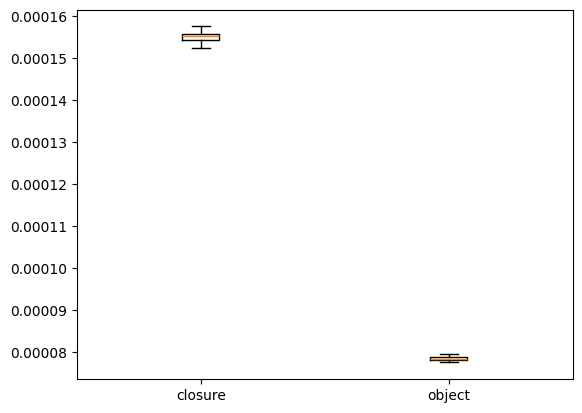

In [24]:
closure_vec = vector(1,2)
add_closure = lambda: vector_add(closure_vec, closure_vec)

object_vec = Vector(1,2)
add_object = lambda: object_vec.vector_add(object_vec)

plot_benchmark(add_closure, add_object, labels=['closure', 'object'])

Here objects are much faster.
We can optimize our closure version of addition by reducing function calls - instead of calling `get` functions we can access the attributes directly:

In [25]:
def vector_add(vec1, vec2):
    return vector(
        vec1(0) + vec2(0), vec1(1) + vec2(1)
    )

Benchmarking again:

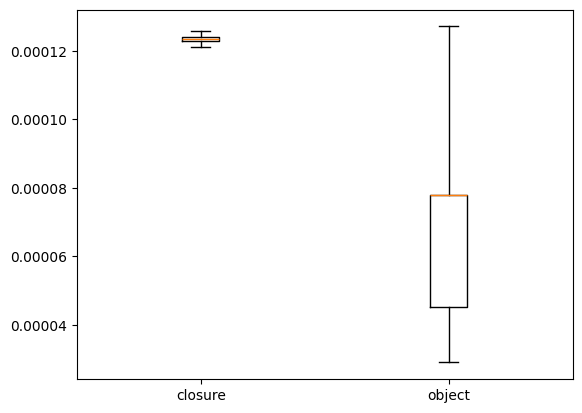

In [26]:
closure_vec = vector(1,2)
add_closure = lambda: vector_add(closure_vec, closure_vec)

object_vec = Vector(1,2)
add_object = lambda: object_vec.vector_add(object_vec)

plot_benchmark(add_closure, add_object, labels=['closure', 'object'])

Better, but still slower than objects.

I think that the reason for faster method calls on objects is deeply connected to accessing methods and attributes on objects; therefore we will benchmark attribute access before digging into it:

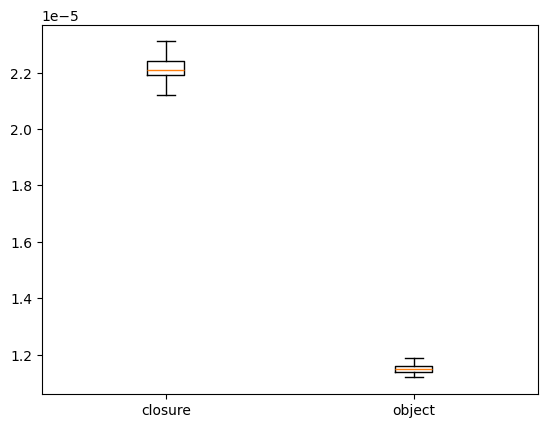

In [27]:
closure_vec = vector(1,2)
access_closure = lambda: closure_vec(0)

object_vec = Vector(1,2)
access_object = lambda: object_vec.x

plot_benchmark(access_closure, access_object, labels=['closure', 'object'])

Also here - objects are faster.

Remember that I said objects are probably optimized better in the language? What is this optimization actually?
I think the answer lies in PEP 659 that was implemented in Python 3.11 (https://peps.python.org/pep-0659/). In this optimization proposal, the Python interpreter recognizes operations that are frequently used and "adapts" itself to execute them faster by using dedicated opcodes.

It will probably be easier to understand by seeing an example. 
Python's interpreter uses an opcode called `LOAD_ATTR` to fetch attributes from instances, classes, modules, etc. This opcode makes the runtime look up the attribute in the object's attribute `__dict__` and load it onto the stack.

We can use `dis` to disassemble a function after the interpreter compiled it, and see this `LOAD_ATTR` opcode with our own eyes:

In [29]:
import dis

dis.dis(lambda: object_vec.x)

  3           0 RESUME                   0
              2 LOAD_GLOBAL              0 (object_vec)
             12 LOAD_ATTR                2 (x)
             32 RETURN_VALUE


Because of PEP 659, when a function performs many attribute-access operations the interpreter declares it as "hot code" and upgrades the `LOAD_ATTR` opcode to `LOAD_ATTR_INSTANCE_VALUE` - the attribute's value (or its location) gets cached so it can be fetched faster than chasing pointers.

In [30]:
dis.dis(access_object, adaptive=True)  # `adaptive=True` makes `dis` print the specialized versions of opcodes

  5           0 RESUME                   0
              2 LOAD_GLOBAL_MODULE       0 (object_vec)
             12 LOAD_ATTR_INSTANCE_VALUE     2 (x)
             32 RETURN_VALUE


Now you probably ask yourself - what happens in closure access?

First let's check un-optimized closure calls:

In [31]:
dis.dis(lambda: closure_vec(0))

  1           0 RESUME                   0
              2 LOAD_GLOBAL              1 (NULL + closure_vec)
             12 LOAD_CONST               1 (0)
             14 CALL                     1
             22 RETURN_VALUE


Pretty simple so far - instead of the `LOAD_ATTR` we have a `LOAD_CONST` to get the `x` value.

Does it get optimized too?

In [32]:
dis.dis(access_closure, adaptive=True)

  2           0 RESUME                   0
              2 LOAD_GLOBAL_MODULE       1 (NULL + closure_vec)
             12 LOAD_CONST               1 (0)
             14 CALL_PY_EXACT_ARGS       1
             22 RETURN_VALUE


Sadly - it isn't; what gets optimized here is the function call, which gets replaced by `CALL_PY_EXACT_ARGS`.
This optimization speeds up function calls when the number of arguments is fixed (i.e. no `*args` or `**kwargs` are passed).

So, it seems like attribute access in objects is indeed optimized better than closure calls.
This is also probably why our addition benchmark showed better results for objects.

## Summary

What have we learnt so far?

We've seen a cool way to define objects without objects, using closures.
Are they any good?
* They are less flexible than objects - we lose the ability to assign class attributes (like `__add__`) to closure-objects, because their type is a `function` which is immutable.
* They don't save us memory - functions in general require more memory overhead than objects.
* They may be faster to create, but slower in attribute and method access; this is crucial because we usually create objects less frequently than using them.

We could entertain ourselves with the idea of making a PEP for future Python versions to optimize closures to the point they are as efficient as objects; but it became clear to me that closures are *less native* in Python, which is a more object oriented language and less functional - carrying functions around feels more clumsy and awkward than using objects.

So it is probably *not* a good idea to go around replacing real objects with closure-objects in your code.
However - this exercise in objects and closures gave us a good opportunity to learn about the internal structure and properties of objects and functions in Python.
I hope you have learned from this notebook at least as much as I did :)